In [ ]:
!pip install monai

In [ ]:
from monai.networks.nets import UNETR
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss
from glob import glob
import torch
import os
from monai.utils import first
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    LoadImaged,
    Activations,
    EnsureChannelFirstD,
    RandSpatialCrop,
    RandFlip,
    ToTensor,
    Resized
)
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
spatial_size=[128, 128, 64]

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstD(keys=["image", "label"]),
    ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="label"),
    Resized(keys=["image", "label"], spatial_size=spatial_size),  # Resize to a larger size to ensure compatibility
    ToTensor()
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstD(keys=["image", "label"]),
    ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="label"),
    Resized(keys=["image", "label"], spatial_size=spatial_size),
    ToTensor()
])


in_dir = '/content/drive/MyDrive/data_processed_/'
model_dir = '/content/drive/MyDrive/data_processed_/'

train_images = sorted(glob(os.path.join(in_dir, "train_images", "*.nii.gz")))
train_labels = sorted(glob(os.path.join(in_dir, "train_labels", "*.nii.gz")))

val_images = sorted(glob(os.path.join(in_dir, "test_images", "*.nii.gz")))
val_labels = sorted(glob(os.path.join(in_dir, "test_labels", "*.nii.gz")))

# Define training and validation data
train_data = [{'image': img, 'label': lbl} for img, lbl in zip(train_images, train_labels)]
val_data = [{'image': img, 'label': lbl} for img, lbl in zip(val_images, val_labels)]

print(train_data)

# Load data using CacheDataset or Dataset for efficient loading
train_ds = CacheDataset(data=train_data, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_data, transform=val_transforms, cache_rate=1.0)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


[{'image': '/content/drive/MyDrive/data_processed_/train_images/Case00_bidmc.nii.gz', 'label': '/content/drive/MyDrive/data_processed_/train_labels/Case00_bidmc.nii.gz'}, {'image': '/content/drive/MyDrive/data_processed_/train_images/Case00_bmc.nii.gz', 'label': '/content/drive/MyDrive/data_processed_/train_labels/Case00_bmc.nii.gz'}, {'image': '/content/drive/MyDrive/data_processed_/train_images/Case00_i2cvb.nii.gz', 'label': '/content/drive/MyDrive/data_processed_/train_labels/Case00_i2cvb.nii.gz'}, {'image': '/content/drive/MyDrive/data_processed_/train_images/Case00_runmc.nii.gz', 'label': '/content/drive/MyDrive/data_processed_/train_labels/Case00_runmc.nii.gz'}, {'image': '/content/drive/MyDrive/data_processed_/train_images/Case01_bmc.nii.gz', 'label': '/content/drive/MyDrive/data_processed_/train_labels/Case01_bmc.nii.gz'}, {'image': '/content/drive/MyDrive/data_processed_/train_images/Case01_i2cvb.nii.gz', 'label': '/content/drive/MyDrive/data_processed_/train_labels/Case01_i2c

Loading dataset: 100%|██████████| 44/44 [02:33<00:00,  3.49s/it]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=1,   # Adjust based on the number of segmentation classes
    img_size=(128, 128, 64),  # Input image size
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0
).to(device)

In [ ]:
loss_function = DiceLoss(sigmoid=True, smooth_nr=1e-5, smooth_dr=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
dice_metric = DiceMetric(include_background=False, reduction="mean_batch", get_not_nans=True)

In [ ]:
import matplotlib.pyplot as plt

def plot_slices(image, label, prediction, slice_idx=32):
    """
    Plot slices of 3D image, label, and prediction volumes at a given slice index.

    Args:
        image (numpy array): 3D image volume of shape (H, W, D) or (C, H, W, D).
        label (numpy array): 3D ground truth label of shape (H, W, D).
        prediction (numpy array): 3D predicted label of shape (H, W, D).
        slice_idx (int): Index of the slice along the Z-axis to visualize.
    """
    # Remove the batch and channel dimensions if present (e.g., (1, 1, H, W, D) -> (H, W, D))
    if image.ndim == 5:
        image = image[0, 0]  # Select first item in batch and first channel
        label = label[0, 0]
        prediction = prediction[0, 0]
    elif image.ndim == 4:
        image = image[0]  # Remove batch dimension if only 4D (e.g., (1, H, W, D))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the chosen slice along the Z-axis
    axes[0].imshow(image[:, :, slice_idx], cmap="gray")
    axes[0].set_title("Image Slice")
    axes[1].imshow(label[:, :, slice_idx], cmap="gray")
    axes[1].set_title("Ground Truth Slice")
    axes[2].imshow(prediction[:, :, slice_idx], cmap="gray")
    axes[2].set_title("Prediction Slice")

    # Turn off axis for a cleaner view
    for ax in axes:
        ax.axis("off")
    plt.show()



In [ ]:
max_epochs = 100
val_interval = 2  # Validate every 2 epochs
best_metric = -1
best_metric_epoch = -1

for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")

    # Training
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch + 1} - Average Training Loss: {epoch_loss:.4f}")

    # Validation
    with torch.no_grad():
      dice_metric.reset()  # Reset the metric at the start of validation
      # for val_data in val_loader:
      #     val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)

      #     # Perform sliding window inference
      #     val_outputs = sliding_window_inference(val_inputs, roi_size=(128, 128, 64), sw_batch_size=4, predictor=model)

      #     # Apply threshold to get binary predictions
      #     val_outputs = torch.sigmoid(val_outputs)  # Apply sigmoid for single channel binary segmentation
      #     val_outputs = (val_outputs > 0.5).float()  # Threshold at 0.5 to get binary predictions
      #     #plot_slices(val_inputs.cpu().numpy(), val_labels.cpu().numpy(), val_outputs.cpu().numpy())
      #     # Update Dice metric with the current batch predictions and labels
      #     dice_metric(y_pred=val_outputs, y=val_labels)
      # # Aggregate the Dice score over the entire validation dataset
      # metric = dice_metric.aggregate()
      # if isinstance(metric, tuple):
      #   metric = torch.mean(torch.tensor(metric)).item()
      #   print(f"Epoch {epoch + 1} - Average test Loss: {metric:.4f}")
      total_batches = 0  # Counter for batches processed
      total_dice = 0  # Variable to accumulate Dice scores for averaging

      for val_data in val_loader:
        val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)

        # Perform sliding window inference
        val_outputs = sliding_window_inference(val_inputs, roi_size=(128, 128, 64), sw_batch_size=4, predictor=model)

        # Apply sigmoid and threshold to get binary predictions
        val_outputs = torch.sigmoid(val_outputs)  # Sigmoid activation for binary segmentation
        val_outputs = (val_outputs > 0.5).float()  # Threshold at 0.5 to get binary predictions

        # Update Dice metric with the current batch predictions and labels
        dice_metric(y_pred=val_outputs, y=val_labels)

        # Aggregate the Dice score for this batch
        batch_dice = dice_metric.aggregate()  # This returns the Dice score for the batch
        if isinstance(batch_dice, tuple):
            batch_dice = torch.mean(torch.tensor(batch_dice)).item()  # Average over tuple, if applicable

        # Accumulate Dice score for averaging
        total_dice += batch_dice
        total_batches += 1

    # Calculate the average Dice score for the entire validation set
    average_dice = total_dice / total_batches

    # Print the average Dice score
    print(f"Epoch {epoch + 1} - Average Test dice score: {average_dice:.4f}")

print(f"Training completed, best metric: {best_metric:.4f} at epoch {best_metric_epoch}")

Epoch 1/100
Epoch 1 - Average Training Loss: 0.4054
Epoch 1 - Average Test dice score: 11.4329
Epoch 2/100
Epoch 2 - Average Training Loss: 0.3632
Epoch 2 - Average Test dice score: 11.4441
Epoch 3/100
Epoch 3 - Average Training Loss: 0.3249
Epoch 3 - Average Test dice score: 11.4512
Epoch 4/100
Epoch 4 - Average Training Loss: 0.2954
Epoch 4 - Average Test dice score: 11.4497
Epoch 5/100
Epoch 5 - Average Training Loss: 0.2738
Epoch 5 - Average Test dice score: 11.4504
Epoch 6/100
Epoch 6 - Average Training Loss: 0.2571
Epoch 6 - Average Test dice score: 11.4506
Epoch 7/100
Epoch 7 - Average Training Loss: 0.2431
Epoch 7 - Average Test dice score: 11.4526
Epoch 8/100
Epoch 8 - Average Training Loss: 0.2334
Epoch 8 - Average Test dice score: 11.4486
Epoch 9/100
Epoch 9 - Average Training Loss: 0.2225
Epoch 9 - Average Test dice score: 11.4434
Epoch 10/100
Epoch 10 - Average Training Loss: 0.2142
Epoch 10 - Average Test dice score: 11.4566
Epoch 11/100
Epoch 11 - Average Training Loss: 

In [ ]:
torch.save(model.state_dict(), "unetr_segmentation.pth")

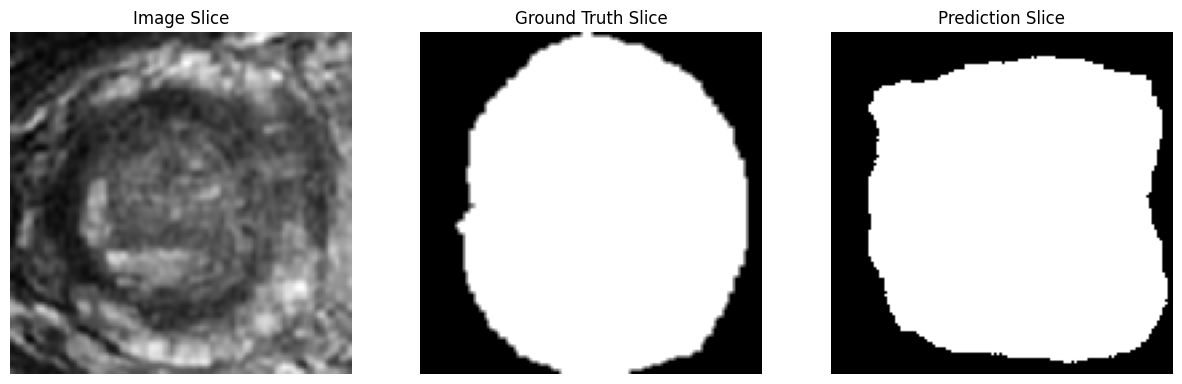

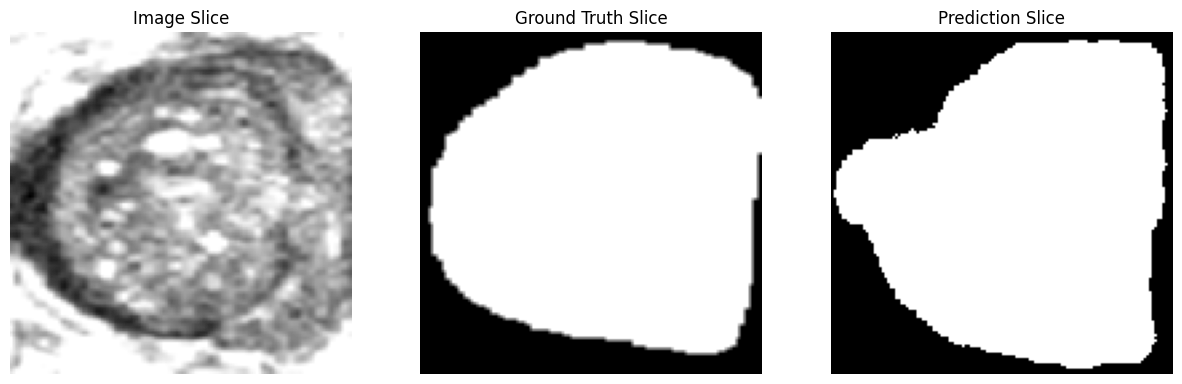

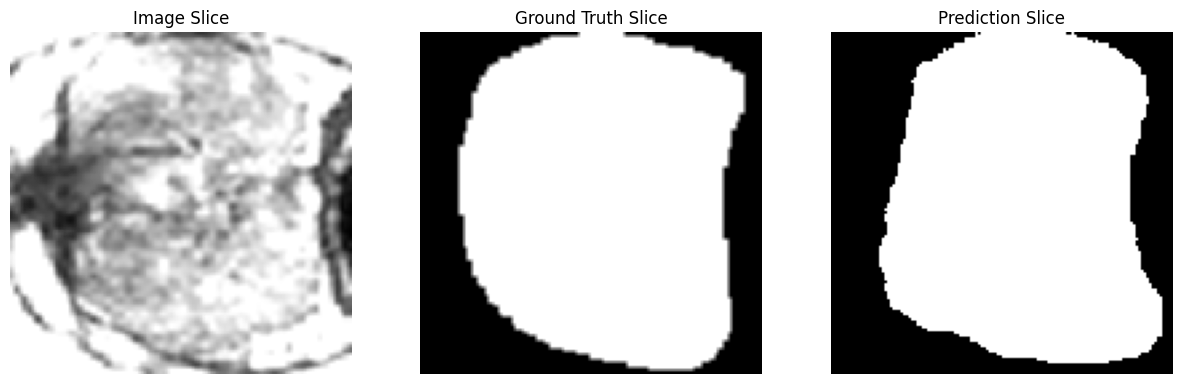

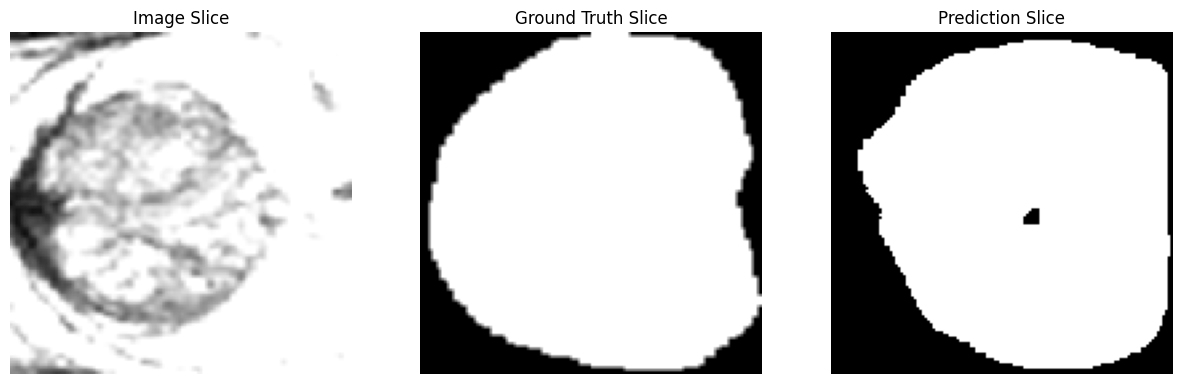

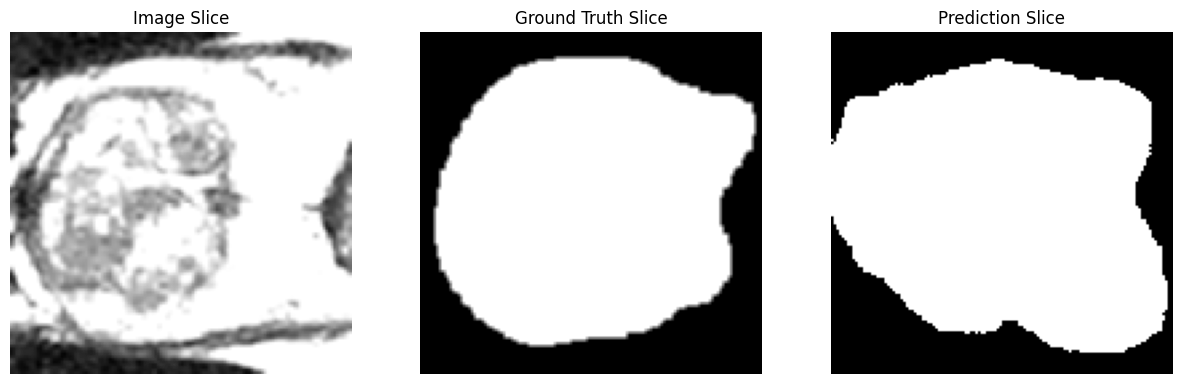

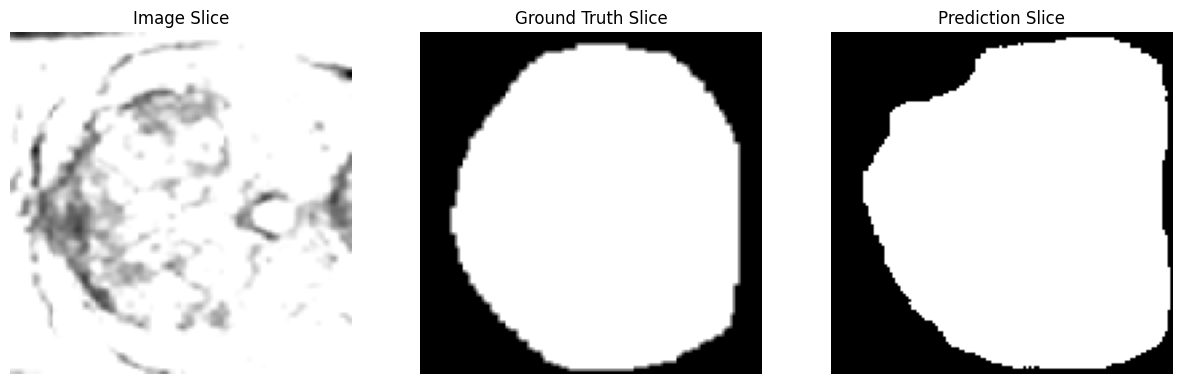

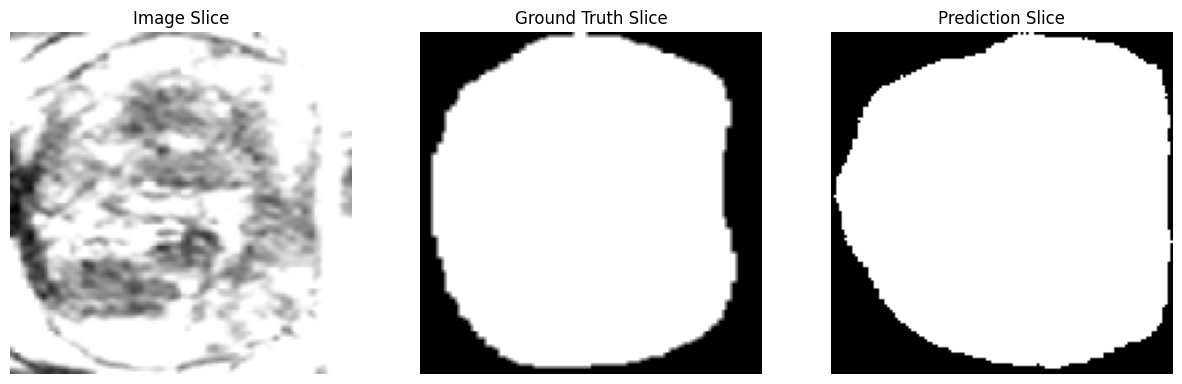

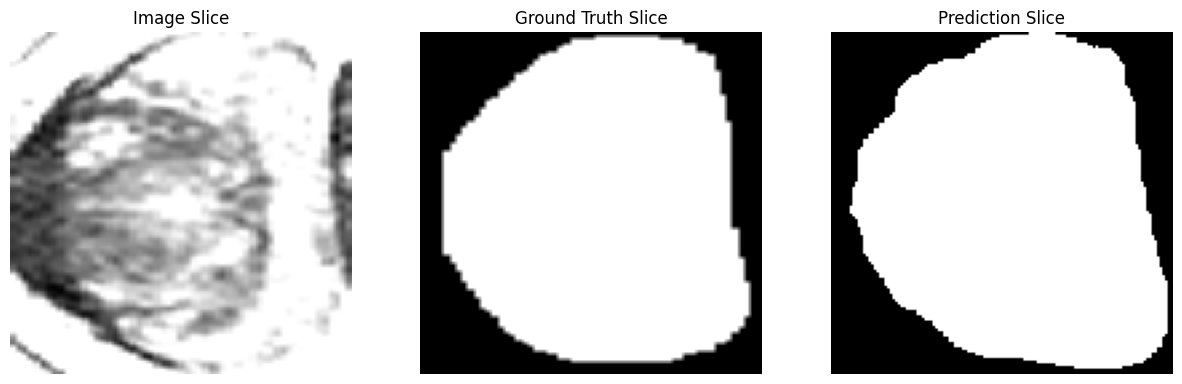

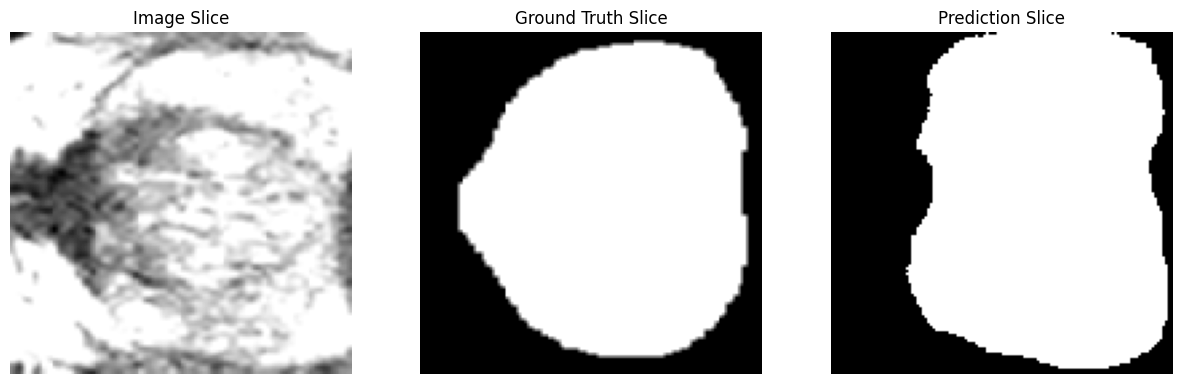

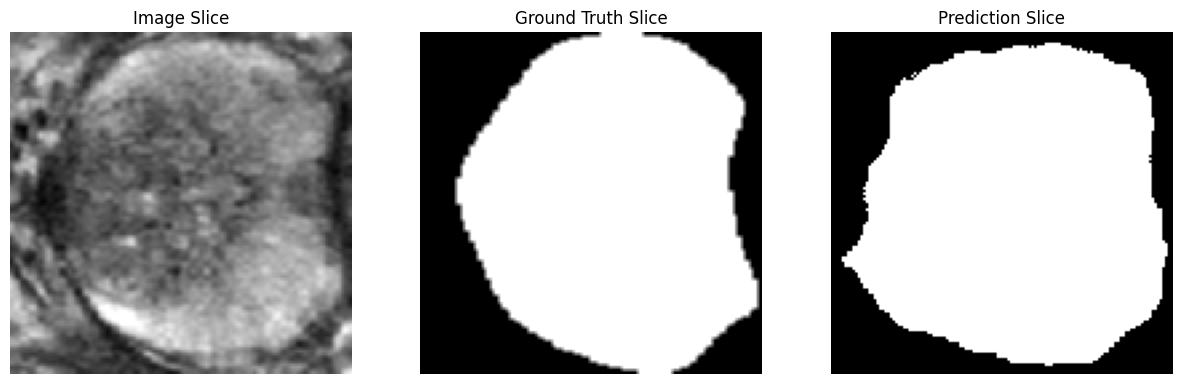

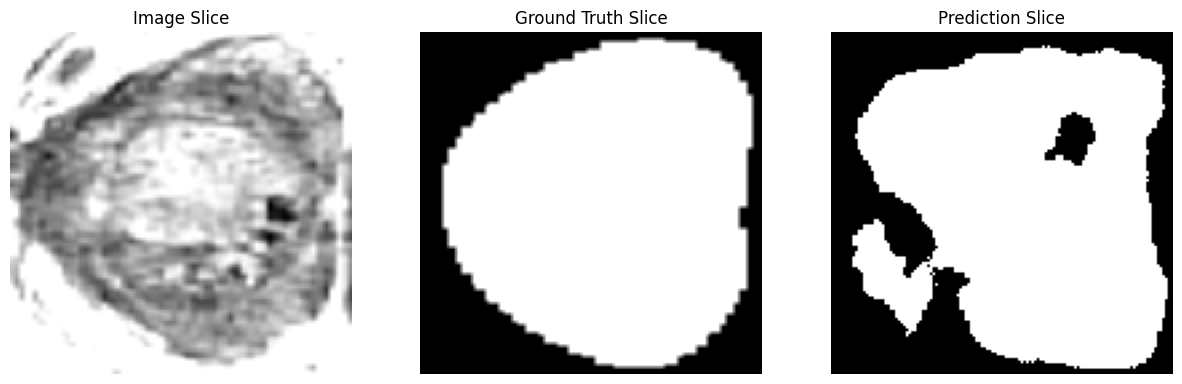

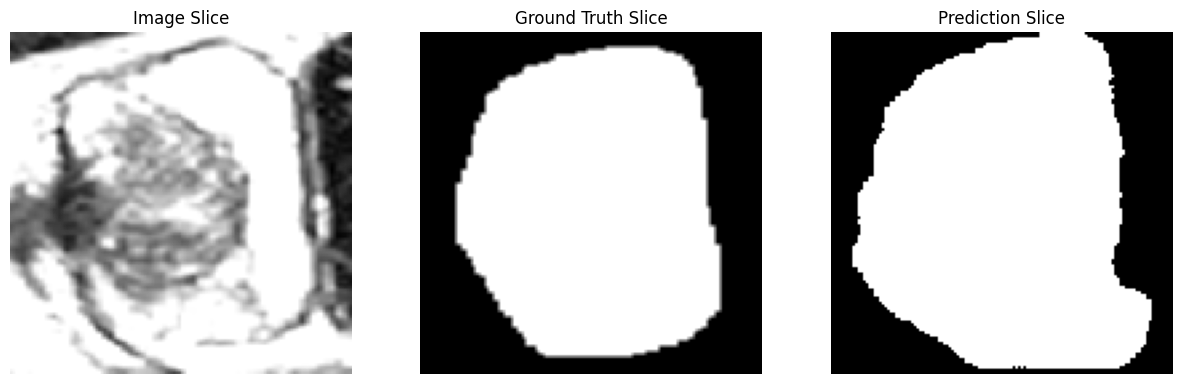

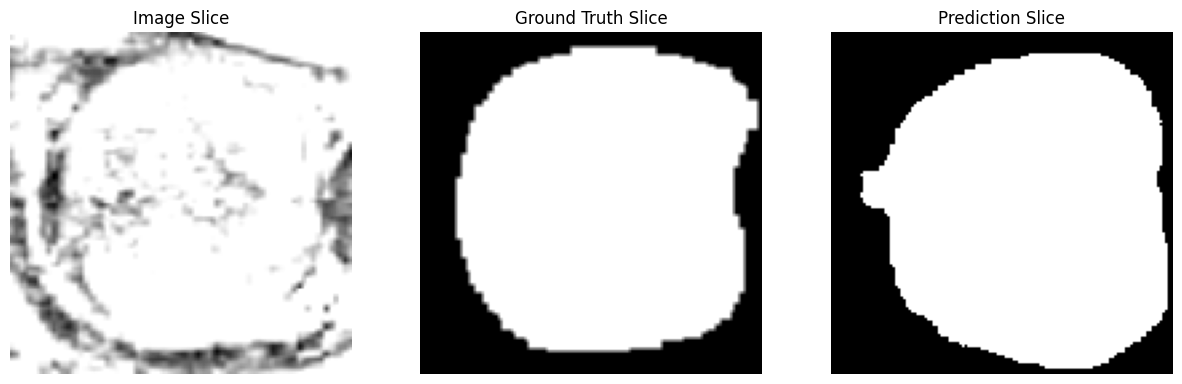

In [ ]:
model.eval()
with torch.no_grad():
      for val_data in val_loader:
          val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)

          # Perform sliding window inference
          val_outputs = sliding_window_inference(val_inputs, roi_size=(128, 128, 64), sw_batch_size=4, predictor=model)

          # Apply threshold to get binary predictions
          val_outputs = torch.sigmoid(val_outputs)  # Apply sigmoid for single channel binary segmentation
          val_outputs = (val_outputs > 0.5).float()  # Threshold at 0.5 to get binary predictions
          plot_slices(val_inputs.cpu().numpy(), val_labels.cpu().numpy(), val_outputs.cpu().numpy())
          # Update Dice metric with the current batch predictions and labels